# Introducción

## Datos

El Portal de Datos Abiertos de Madrid y EMT proporciona información detallada del uso de BiciMAD, con registros históricos de cada trayecto desde 2014. Por ejemplo, es posible obtener el número de enganches (retiradas) de bicicletas en cada estación y hora. Utilizaremos los datos de usos por estación de BiciMAD para inferir la demanda relativa en distintos tipos de ubicaciones.

**Supondremos**, como punto de partida, que cada viaje en bici pública representa aproximadamente un viaje potencial en moto compartida en la misma zona. 

# EDA

Obtendremos los datos del portan de datos abiertos de la cominidad de Madrid

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, asin
import folium
from folium.plugins import HeatMap


In [2]:
import pandas as pd

# 1. Definir rutas a los 5 CSV completos
archivos = {
    "febrero":     "trips_23_02_February.csv",
    "abril":       "trips_22_04_April.csv",
    "julio":       "trips_22_07_July.csv",
    "septiembre":  "trips_22_09_September.csv",
    "diciembre":   "trips_22_12_December.csv"
}

# 2. Cargar cada CSV completo y añadir una columna 'mes'
dfs = []
for mes, ruta in archivos.items():
    df = pd.read_csv(ruta, sep=';', encoding='utf-8', low_memory=False)
    df['mes'] = mes
    dfs.append(df)

# 3. Concatenar todos los dataframes sin filtrar semanas
df = pd.concat(dfs, ignore_index=True)

# 4. Mostrar información básica
print("Total de registros cargados:", len(df))
print("Número de columnas:", df.shape[1])
print("Primeras filas:")
print(df.head())

# 5. Guardar el dataset completo en un nuevo CSV
df.to_csv("merge_full.csv", index=False)
print("Dataset completo guardado como 'merge_full.csv'.")


Total de registros cargados: 3062008
Número de columnas: 20
Primeras filas:
        fecha  idBike  fleet  trip_minutes  \
0         NaN     NaN    NaN           NaN   
1  2023-02-01  7337.0    1.0          5.52   
2         NaN     NaN    NaN           NaN   
3  2023-02-01  5098.0    1.0          0.32   
4         NaN     NaN    NaN           NaN   

                                  geolocation_unlock  \
0                                                NaN   
1  {'type': 'Point', 'coordinates': [-3.6956178, ...   
2                                                NaN   
3  {'type': 'Point', 'coordinates': [-3.7022591, ...   
4                                                NaN   

                   address_unlock          unlock_date locktype unlocktype  \
0                             NaN                  NaN      NaN        NaN   
1              'Calle Jesús nº 1'  2023-02-01T00:00:10  STATION    STATION   
2                             NaN                  NaN      NaN        NaN  

In [3]:


# Asegurar que la fecha esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Eliminar filas sin estación de desbloqueo
df = df[df['unlock_station_name'].notna()]

# Contar trayectos por estación
top_estaciones = df['unlock_station_name'].value_counts().reset_index()
top_estaciones.columns = ['Estación', 'Número de trayectos']

# Seleccionar solo las 10 más activas
top_10 = top_estaciones.head(10)

# Mostrar en consola
print(top_10)

                      Estación  Número de trayectos
0      39 - Plaza de la Cebada                17793
1       53 - Plaza de Lavapiés                16992
2             167 - Segovia 45                14093
3     212 - Marqués de Vadillo                13647
4            41 - Antón Martín                13002
5                200 - Quevedo                12882
6        85 - Puerta de Madrid                12826
7        45 - Puerta de Toledo                11739
8  37 - Plaza de San Francisco                11370
9      246 - Santa Engracia 87                11303


C:\Users\carlo\AppData\Local\Temp\ipykernel_24660\3988306197.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dias_muestra = dias_unicos.groupby('weekday', group_keys=False).apply(


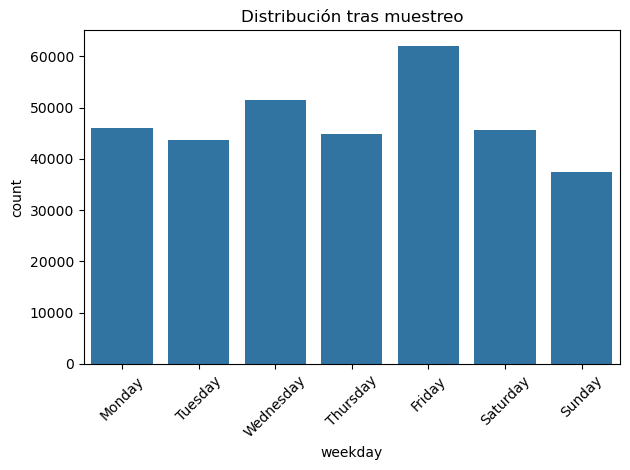

✅ Dataset reducido guardado como 'dataset_reducido.csv'


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Asegurar formato datetime y limpiar
df['unlock_date'] = pd.to_datetime(df['unlock_date'], errors='coerce')
df = df.dropna(subset=['unlock_date', 'trip_minutes']).copy()

# Pasar minutos a segundos
df['trip_seconds'] = df['trip_minutes'] * 60

# Mantener viajes entre 1 min y 1 h
df = df[(df['trip_seconds'] >= 60) & (df['trip_seconds'] <= 3600)]


# 2. Extraer fecha y día
df['fecha_sola'] = df['unlock_date'].dt.date
df['weekday'] = df['unlock_date'].dt.day_name()

# 3. Días únicos
dias_unicos = df[['fecha_sola', 'weekday']].drop_duplicates()

# 4. Muestrear hasta 5 días por grupo (según disponibilidad)
dias_muestra = dias_unicos.groupby('weekday', group_keys=False).apply(
    lambda x: x.sample(n=min(5, len(x)), random_state=42)
)

# 5. Filtrar el dataframe con esos días
df = df[df['fecha_sola'].isin(dias_muestra['fecha_sola'])]

# 6. Visualizar distribución
orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(x='weekday', data=df, order=orden)
plt.title("Distribución tras muestreo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Guardar
df.to_csv("dataset_reducido.csv", index=False)
print("✅ Dataset reducido guardado como 'dataset_reducido.csv'")


In [5]:
# 1. Cargar dataset reducido
df = pd.read_csv("dataset_reducido.csv", low_memory = False)

In [6]:
# 2. Asegurar que unlock_date y trip_minutes son válidos
df['unlock_date'] = pd.to_datetime(df['unlock_date'], errors='coerce')
df = df.dropna(subset=['unlock_date', 'trip_minutes']).copy()
df = df[(df['trip_minutes'] >= 1) & (df['trip_minutes'] <= 60)]  # 1min a 60min

In [7]:
# 3. Extraer coordenadas seguras
def extract_coords(col):
    def _parse(s):
        try:
            geo = ast.literal_eval(s)
            return pd.Series(geo['coordinates'], index=['lon', 'lat'])
        except:
            return pd.Series([np.nan, np.nan], index=['lon', 'lat'])
    return df[col].apply(_parse)

df[['lon_start','lat_start']] = extract_coords('geolocation_unlock')
df[['lon_end','lat_end']]     = extract_coords('geolocation_lock')

In [8]:
# 4. Eliminar filas con coordenadas faltantes
df = df.dropna(subset=['lon_start', 'lat_start', 'lon_end', 'lat_end'])

In [9]:
# 5. Función de distancia haversine
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * 6371 * asin(sqrt(a))

# 6. Calcular distancia y velocidad
df['distance_km'] = df.apply(
    lambda r: haversine(r['lon_start'], r['lat_start'], r['lon_end'], r['lat_end']),
    axis=1
)

In [10]:
df['speed_kmh'] = df['distance_km'] / (df['trip_minutes'] / 60)

In [11]:
# 7. Eliminar velocidades o distancias inválidas (opcional)
df = df[(df['distance_km'] > 0.05) & (df['distance_km'] < 50)]
df = df[(df['speed_kmh'] > 1) & (df['speed_kmh'] < 50)]

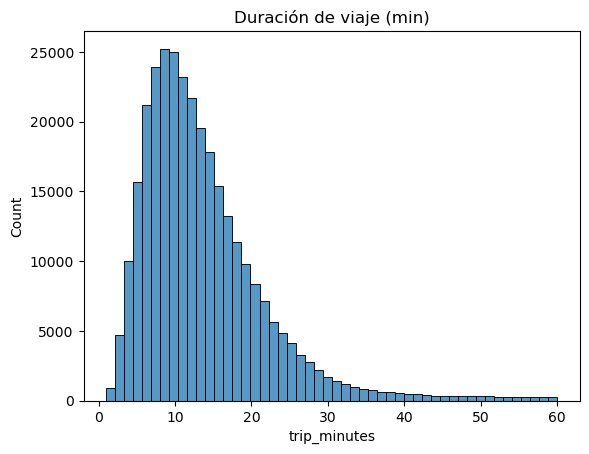

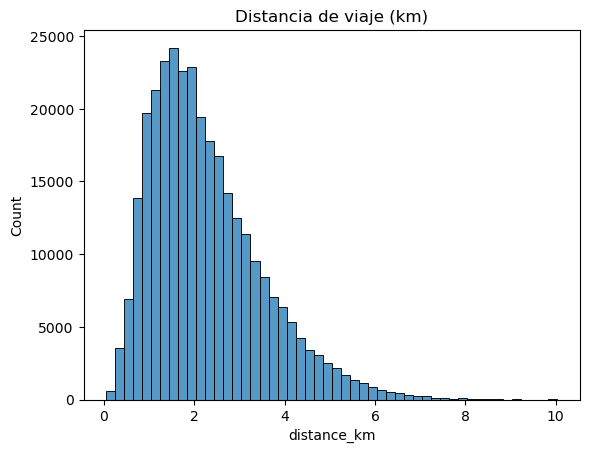

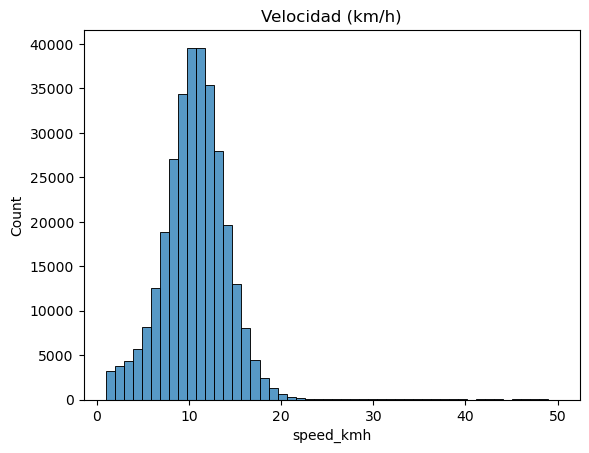

In [12]:
# 8. Graficar
plt.figure()
sns.histplot(df['trip_minutes'], bins=50)
plt.title("Duración de viaje (min)")

plt.figure()
sns.histplot(df['distance_km'], bins=50)
plt.title("Distancia de viaje (km)")

plt.figure()
sns.histplot(df['speed_kmh'], bins=50)
plt.title("Velocidad (km/h)")

plt.show()

Text(0.5, 1.0, 'Velocidad vs Tiempo')

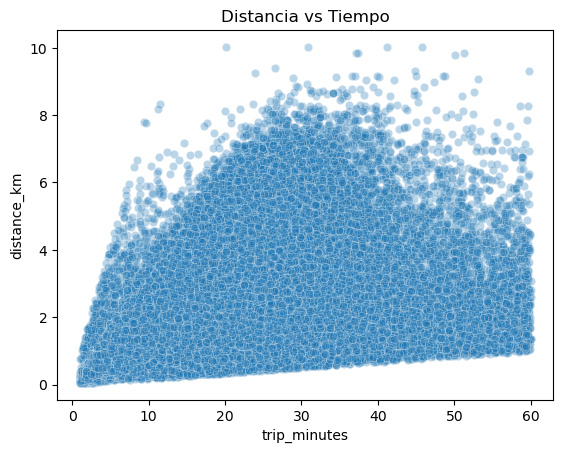

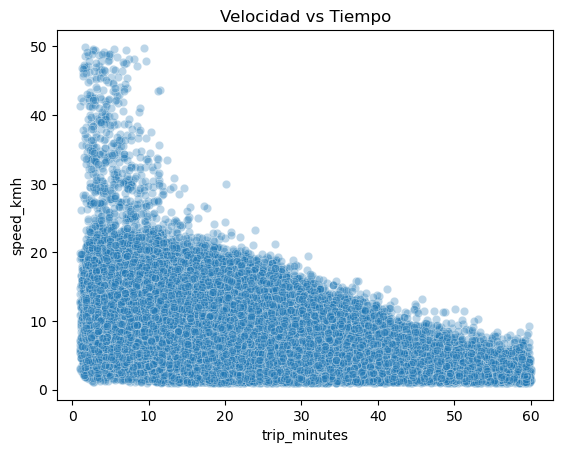

In [13]:
plt.figure()
sns.scatterplot(x='trip_minutes', y='distance_km', data=df, alpha=0.3)
plt.title("Distancia vs Tiempo")


plt.figure()
sns.scatterplot(x='trip_minutes', y='speed_kmh', data=df, alpha=0.3)
plt.title("Velocidad vs Tiempo")



Text(0.5, 1.0, 'Viajes por día de la semana')

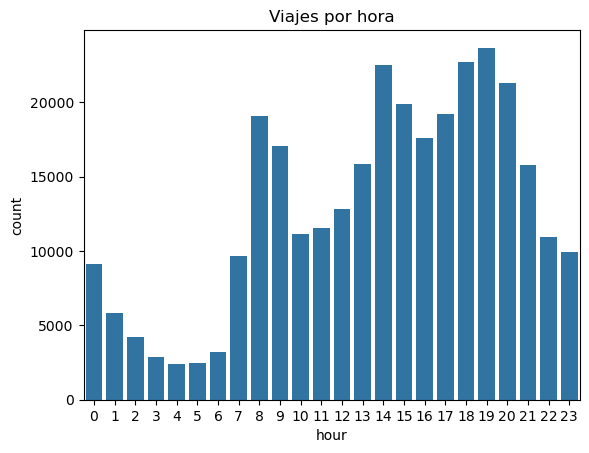

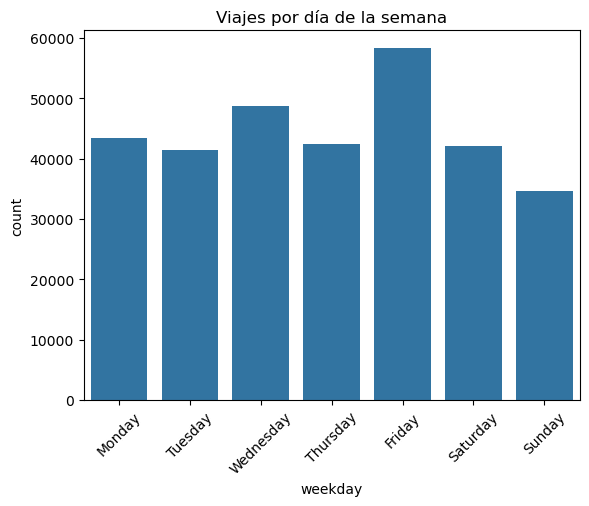

In [14]:
# Hora del día
df['hour'] = df['unlock_date'].dt.hour
plt.figure()
sns.countplot(x='hour', data=df)
plt.title("Viajes por hora")
#plt.savefig("viajes_por_hora.png")

In [15]:
df = df.dropna(subset=['fecha', 'geolocation_unlock', 'unlock_station_name'])

# Extraer lat/lon desde la columna de coordenadas (string tipo diccionario)
def extract_coords(geo_str):
    try:
        geo = ast.literal_eval(geo_str)
        return pd.Series(geo['coordinates'], index=['lon', 'lat'])
    except:
        return pd.Series([None, None], index=['lon', 'lat'])

df[['lon', 'lat']] = df['geolocation_unlock'].apply(extract_coords)

# Agrupar por estación y contar viajes + promediar coordenadas
estaciones = df.groupby('unlock_station_name').agg({
    'lat': 'mean',
    'lon': 'mean',
    'unlock_station_name': 'count'
}).rename(columns={'unlock_station_name': 'num_viajes'}).reset_index()

# Crear el mapa
mapa = folium.Map(location=[40.4168, -3.7038], zoom_start=13)

# Añadir círculos por estación
for _, row in estaciones.iterrows():
    if pd.notna(row['lat']) and pd.notna(row['lon']):
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=max(4, min(row['num_viajes'] / 500, 20)),  # Escala proporcional
            popup=f"{row['unlock_station_name']}<br>Viajes: {row['num_viajes']}",
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(mapa)

# Guardar el mapa
#mapa.save("mapa_calor_todas_estaciones.html")
mapa

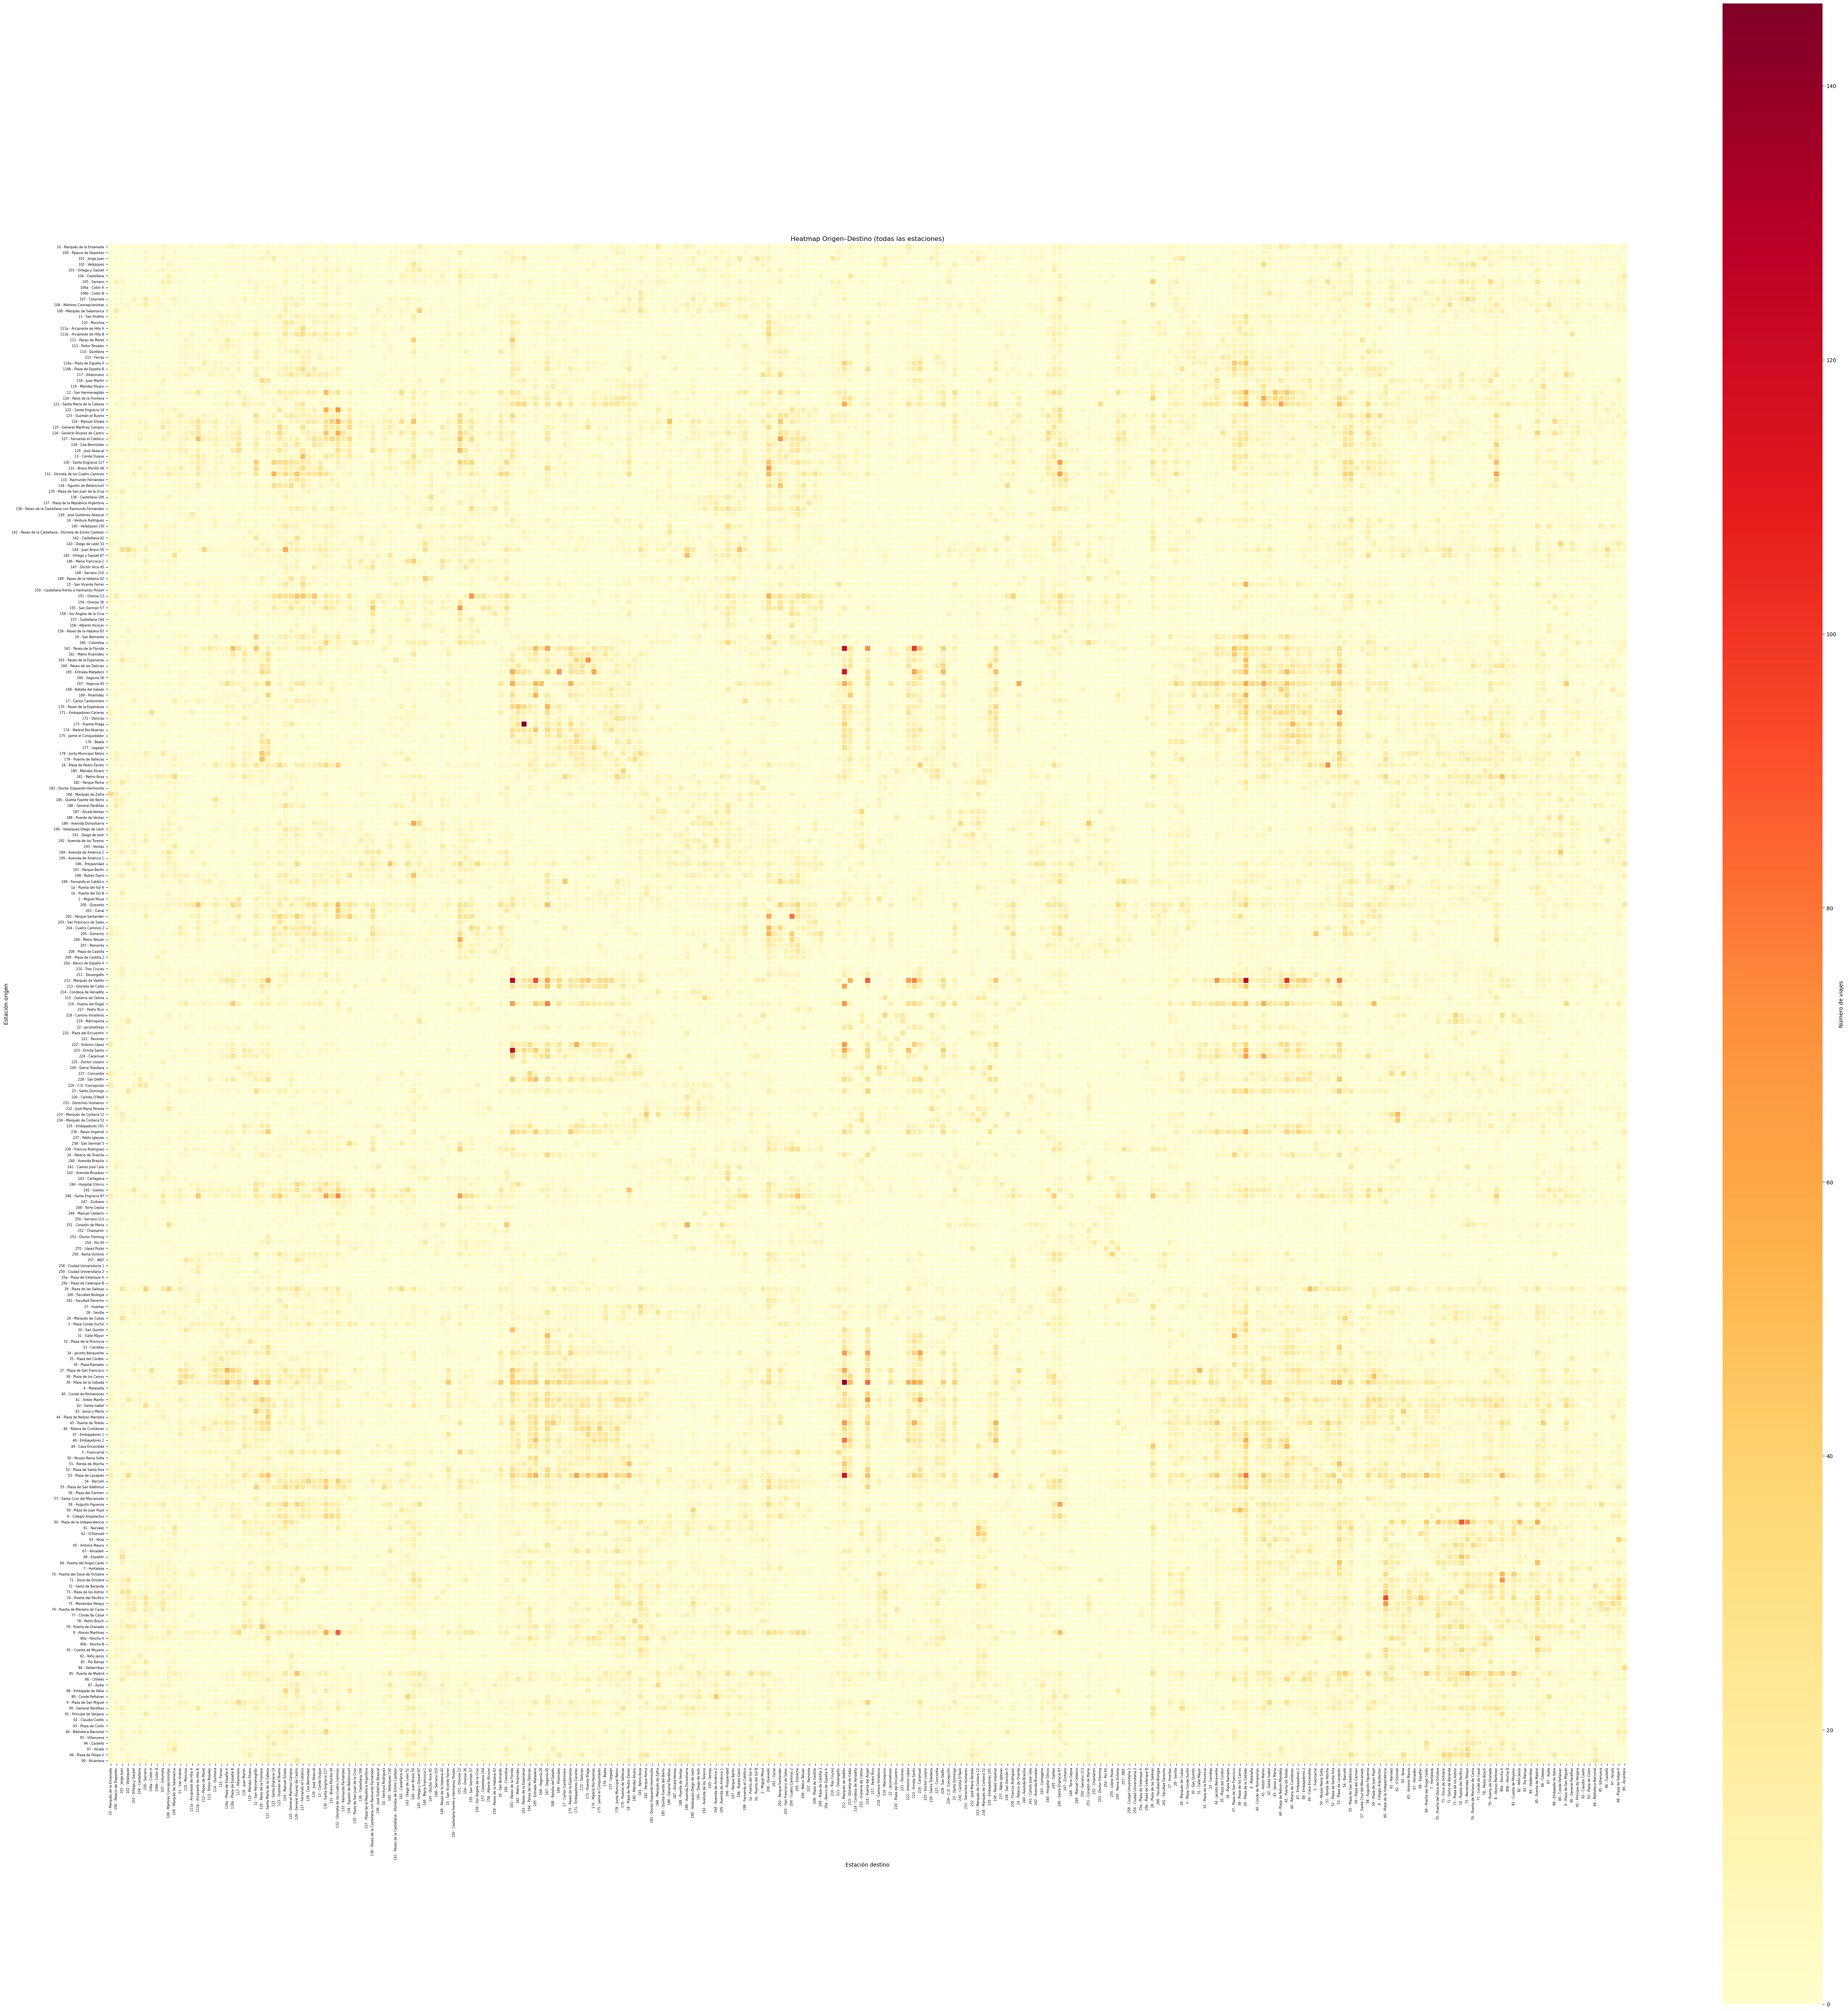

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Limpia filas sin estación de origen o destino
df = df.dropna(subset=["unlock_station_name", "lock_station_name"])

# 2. Agrupa por origen y destino, contando viajes
od = (
    df
    .groupby(["unlock_station_name", "lock_station_name"])
    .size()
    .reset_index(name="viajes")
)

# 3. Pivot para crear la matriz O-D completa
od_matrix = od.pivot(
    index="unlock_station_name",
    columns="lock_station_name",
    values="viajes"
).fillna(0).astype(int)

# 4. Ajustar dinámicamente el tamaño de la figura
n_origenes  = od_matrix.shape[0]
n_destinos  = od_matrix.shape[1]
fig_w = max(10, n_destinos * 0.2)   # 0.2 inch por estación, mínimo 10
fig_h = max(8,  n_origenes * 0.2)    # 0.2 inch por estación, mínimo 8

plt.figure(figsize=(fig_w, fig_h))

# 5. Dibuja el heatmap sin anotaciones
sns.heatmap(
    od_matrix,
    cmap="YlOrRd",
    linewidths=0.3,
    cbar_kws={"label": "Número de viajes"},
    square=True,
    xticklabels=True,
    yticklabels=True
)

# 6. Etiquetas y formato
plt.title("Heatmap Origen–Destino (todas las estaciones)")
plt.xlabel("Estación destino")
plt.ylabel("Estación origen")

# Rotar etiquetas del eje X y ajustar márgenes
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()

# 7. Guardar y mostrar
plt.savefig("heatmap_od_todas_estaciones.png", dpi=200)
plt.show()


## Creación dataset de motos

In [61]:
import pandas as pd
import numpy as np
import ast
from math import radians, sin, cos, sqrt, asin

# --------------------------------------
# 1. Parámetros de simulación realista
# --------------------------------------
N = 307236  # número de viajes a simular

# Parámetros de flota Cooltra Madrid
MADRID_FLEET_SIZE = 2000                        # ≈2 000 motos en Madrid :contentReference[oaicite:10]{index=10}
BATTERY_KWH        = 2.8                         # 2×1.4 kWh :contentReference[oaicite:11]{index=11}
AUTONOMY_KM        = 80                          # hasta 80 km reales :contentReference[oaicite:12]{index=12}
CHARGE_TIME_H      = 3.5                         # carga rápida en 3,5 h (7 h estándar) 
MAX_SPEED_KMH      = 45                          # límite legal 45 km/h :contentReference[oaicite:14]{index=14}
CONSUMPTION_KWH_PER_KM = BATTERY_KWH / AUTONOMY_KM  # ≈0.035 kWh/km




# Distancia: distribución Gamma para cola larga (media ≈ 2.3 km)
DIST_SHAPE = 2.0
DIST_SCALE = 1.15
MIN_DIST_KM = 0.2
MAX_DIST_KM = 10.0



# Ajustes de distribución de velocidades (normal centrada en 12 km/h)
SPEED_MEAN = 12.0   # km/h
SPEED_STD  = 3.0
MIN_SPEED  = 5.0
MAX_SPEED  = MAX_SPEED_KMH

# Consumo energético aproximado (kWh/km)
KWH_PER_KM = 0.15

# Fechas: año 2023
START_DATE = pd.Timestamp("2022-04-01")
END_DATE   = pd.Timestamp("2023-02-28")

# --------------------------------------
# 2. Cargar datos BiciMAD para O-D & horarios
# --------------------------------------
df_bici = pd.read_csv("dataset_reducido.csv", sep=",", encoding="utf-8", low_memory=False)
df_bici['unlock_date'] = pd.to_datetime(df_bici['unlock_date'], errors='coerce')

# Extraer estaciones de origen y destino con sus coordenadas
def extract_coords(s):
    try:
        geo = ast.literal_eval(s)
        return geo["coordinates"]
    except:
        return [np.nan, np.nan]

coords = np.vstack(df_bici["geolocation_unlock"].apply(extract_coords).values)
stations = pd.DataFrame({
    "station": df_bici["unlock_station_name"],
    "lon": coords[:,0],
    "lat": coords[:,1]
}).drop_duplicates().reset_index(drop=True)

# Probabilidades de origen y destino según uso BiciMAD
p_orig = df_bici["unlock_station_name"].value_counts(normalize=True)
p_dest = df_bici["lock_station_name"].value_counts(normalize=True)

# Distribución horaria de BiciMAD como proxy
df_bici["hour"] = df_bici["unlock_date"].dt.hour
hour_probs = df_bici["hour"].value_counts(normalize=True).sort_index()

# --------------------------------------
# 3. Simulación de viajes
# --------------------------------------
np.random.seed(42)

# 3.1 Selección de origen y destino
orig_stations = np.random.choice(p_orig.index, size=N, p=p_orig.values)
dest_stations = np.random.choice(p_dest.index, size=N, p=p_dest.values)
# Evitar origen == destino
mask = orig_stations == dest_stations
while mask.any():
    dest_stations[mask] = np.random.choice(p_dest.index, size=mask.sum(), p=p_dest.values)
    mask = orig_stations == dest_stations

# 3.2 Extraer coordenadas de origen/destino
orig_coords = stations.set_index("station").loc[orig_stations, ["lon","lat"]].values
dest_coords = stations.set_index("station").loc[dest_stations, ["lon","lat"]].values

# 3.3 Ajustar rango mínimo y máximo de distancia (0.2–10 km)
distances = np.random.gamma(DIST_SHAPE, DIST_SCALE, size=N)
MIN_DIST_KM = 0.2
MAX_DIST_KM = 10.0
distances = np.clip(distances, MIN_DIST_KM, MAX_DIST_KM)
distances = np.clip(distances, MIN_DIST_KM, MAX_DIST_KM)
energies = distances * CONSUMPTION_KWH_PER_KM  # kWh consumidos


# 3.4 Simular velocidades (Normal) y clip
speeds = np.random.normal(loc=SPEED_MEAN, scale=SPEED_STD, size=N)
speeds = np.clip(speeds, MIN_SPEED, MAX_SPEED)

# 3.5 Calcular duraciones (min) y energía (kWh)
durations = distances / speeds * 60  # minutos
energies  = distances * KWH_PER_KM  # kWh

# 3.6 Simular timestamps de desbloqueo
# Fecha aleatoria
rand_seconds = np.random.randint(START_DATE.value//10**9, END_DATE.value//10**9, size=N)
rand_dates = pd.to_datetime(rand_seconds, unit="s")
# Ajustar hora según distribución real
rand_hours = np.random.choice(hour_probs.index, size=N, p=hour_probs.values)
# Usar rand_dates.hour, no rand_dates.dt.hour
hour_delta = rand_hours - rand_dates.hour
unlock_dates = rand_dates + pd.to_timedelta(hour_delta, unit="h") \
                          + pd.to_timedelta(np.random.randint(0,60,size=N), unit="m")
lock_dates = unlock_dates + pd.to_timedelta(durations, unit="m")

# Definir IDs de vehículo dentro de la flota de Madrid
vehicle_ids = np.random.randint(1, MADRID_FLEET_SIZE+1, size=N)


# --------------------------------------
# 4. Ensamblar DataFrame final y exportar
# --------------------------------------
df_moto = pd.DataFrame({
    "vehicre_ids":         vehicle_ids,
    "unlock_date":         unlock_dates,
    "lock_date":           lock_dates,
    "fleet":               1,
    "trip_minutes":        durations,
    "geolocation_unlock":  [str({"type":"Point","coordinates":[lon,lat]}) for lon,lat in orig_coords],
    "geolocation_lock":    [str({"type":"Point","coordinates":[lon,lat]}) for lon,lat in dest_coords],
    "unlocktype":          "STATION",
    "locktype":            "STATION",
    "unlock_station_name": orig_stations,
    "lock_station_name":   dest_stations
})

df_moto.to_csv("motos.csv", index=False)
print(f"✅ motos.csv generado correctamente con {len(df_moto)} registros simulados.")


✅ motos.csv generado correctamente con 307236 registros simulados.


In [62]:
df_moto = pd.read_csv("motos.csv")

In [63]:
print("Después de cargar:", len(df_moto))



Después de cargar: 307236


In [64]:
df_moto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307236 entries, 0 to 307235
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   vehicre_ids          307236 non-null  int64  
 1   unlock_date          307236 non-null  object 
 2   lock_date            307236 non-null  object 
 3   fleet                307236 non-null  int64  
 4   trip_minutes         307236 non-null  float64
 5   geolocation_unlock   307236 non-null  object 
 6   geolocation_lock     307236 non-null  object 
 7   unlocktype           307236 non-null  object 
 8   locktype             307236 non-null  object 
 9   unlock_station_name  307236 non-null  object 
 10  lock_station_name    307236 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 25.8+ MB


Text(0.5, 1.0, 'Duración de viaje (min)')

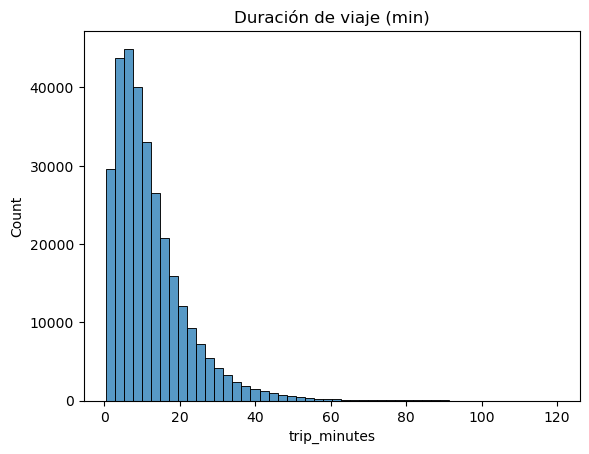

In [65]:
# 8. Graficar
plt.figure()
sns.histplot(df_moto['trip_minutes'], bins=50)
plt.title("Duración de viaje (min)")


In [66]:
df_moto.head()

,vehicre_ids,unlock_date,lock_date,fleet,trip_minutes,geolocation_unlock,geolocation_lock,unlocktype,locktype,unlock_station_name,lock_station_name
0,175,2022-06-03 18:08:59,2022-06-03 19:09:18.036573290,1,60.317276,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,52 - Plaza de Santa Ana,123 - Guzmán el Bueno
1,1538,2022-11-02 05:42:52,2022-11-02 05:52:49.795841866,1,9.963264,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,57 - Santa Cruz del Marcenado,120 - Palos de la Frontera
2,1183,2022-05-20 10:13:49,2022-05-20 10:26:10.755203206,1,12.362587,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,186 - General Pardiñas,181 - Retiro-Ibiza
3,15,2022-12-17 19:47:42,2022-12-17 19:53:18.383412048,1,5.606390,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,107 - Columela,161 - Paseo de la Florida
4,890,2022-04-25 09:53:06,2022-04-25 10:08:48.686277996,1,15.711438,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,132 - Glorieta de los Cuatro Caminos,53 - Plaza de Lavapiés


## Bici vs Moto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from math import radians, sin, cos, sqrt, asin
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans

df_bici = pd.read_csv("dataset_reducido.csv", sep=",", encoding="utf-8", low_memory=False)
df_moto = pd.read_csv("motos.csv", sep=",", encoding="utf-8", low_memory=False)


In [2]:
print("Después de cargar:", len(df_moto))

Después de cargar: 307236


In [3]:
#Convertir fechas
df_bici['fecha'] = pd.to_datetime(df_bici['unlock_date'], errors='coerce')
df_moto['fecha'] = pd.to_datetime(df_moto['unlock_date'], errors='coerce')

# Eliminar registros sin datos esenciales
df_bici = df_bici.dropna(subset=['fecha', 'trip_minutes', 'geolocation_unlock', 'geolocation_lock'])
df_moto = df_moto.dropna(subset=['fecha', 'trip_minutes', 'geolocation_unlock', 'geolocation_lock'])

In [4]:
print("Después de dropna:", len(df_moto))

Después de dropna: 307236


In [5]:
import re
import ast
import pandas as pd
import numpy as np

# Función que opera sobre UN string, no sobre una columna
def parse_coords(s):
    try:
        s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', str(s))  # elimina np.float64(...)
        geo = ast.literal_eval(s)
        return pd.Series(geo['coordinates'], index=['lon', 'lat'])
    except:
        return pd.Series([np.nan, np.nan], index=['lon', 'lat'])


In [6]:
df_bici[['lon_start','lat_start']] = df_bici['geolocation_unlock'].apply(parse_coords)
df_bici[['lon_end','lat_end']]     = df_bici['geolocation_lock'].apply(parse_coords)

df_moto[['lon_start','lat_start']] = df_moto['geolocation_unlock'].apply(parse_coords)
df_moto[['lon_end','lat_end']]     = df_moto['geolocation_lock'].apply(parse_coords)


In [7]:
df_bici = df_bici.dropna(subset=['lon_start','lat_start','lon_end','lat_end'])
df_moto = df_moto.dropna(subset=['lon_start','lat_start','lon_end','lat_end'])


In [8]:
# Haversine
def haversine(lon1, lat1, lon2, lat2):
    lon1,lat1,lon2,lat2 = map(radians, [lon1,lat1,lon2,lat2])
    dlon, dlat = lon2-lon1, lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2*6371*asin(sqrt(a))


In [9]:
df_bici['distance_km'] = df_bici.apply(
    lambda r: haversine(r.lon_start, r.lat_start, r.lon_end, r.lat_end), axis=1)
df_moto['distance_km'] = df_moto.apply(
    lambda r: haversine(r.lon_start, r.lat_start, r.lon_end, r.lat_end), axis=1)

for df in (df_bici, df_moto):
    df['trip_seconds'] = df['trip_minutes'] * 60
    df['speed_kmh']    = df['distance_km'] / (df['trip_seconds'] / 3600)

In [10]:
# 3. FILTRAR RANGOS PLAUSIBLES --------------------------------------------
df_bici = df_bici[(df_bici['trip_seconds'].between(60, 3600)) &
                  (df_bici['speed_kmh'].between(0, 50))]

df_moto = df_moto[(df_moto['trip_seconds'].between(60, 5400)) &
                  (df_moto['speed_kmh'].between(0, 80))]

print(len(df_bici), "viajes bici válidos")
print(len(df_moto), "viajes moto válidos")

330560 viajes bici válidos
286916 viajes moto válidos


In [11]:
# Bici
df_bici = df_bici[(df_bici['trip_seconds'] >= 60) & (df_bici['trip_seconds'] <= 3600)]
df_bici = df_bici[(df_bici['speed_kmh'] > 0) & (df_bici['speed_kmh'] <= 50)]

# Moto
df_moto = df_moto[(df_moto['trip_seconds'] >= 60) & (df_moto['trip_seconds'] <= 5400)]
df_moto = df_moto[(df_moto['speed_kmh'] > 0) & (df_moto['speed_kmh'] <= 80)]


In [12]:
# ------------------------
# 2. ESTADÍSTICAS DESCRIPTIVAS
# ------------------------
desc_bici = df_bici[['trip_minutes','distance_km','speed_kmh']].describe()
desc_moto = df_moto[['trip_minutes','distance_km','speed_kmh']].describe()


In [115]:
desc_bici

,trip_minutes,distance_km,speed_kmh
count,312677.000000,312677.000000,312677.000000
mean,13.845589,2.253546,10.593291
std,8.441387,1.232245,3.535430
min,1.000000,0.005014,0.014656
25%,8.150000,1.345296,8.596088
50%,11.950000,2.010643,10.715339
75%,17.220000,2.933535,12.753293
max,59.980000,10.030109,49.944662


In [116]:
desc_moto

,trip_minutes,distance_km,speed_kmh
count,286916.000000,286916.000000,286916.000000
mean,13.008970,2.822463,20.082686
std,9.582404,1.479633,16.661193
min,1.000328,0.012269,0.040825
25%,6.295867,1.693257,7.848507
50%,10.465799,2.653340,14.826017
75%,16.867664,3.758117,27.236767
max,89.837842,10.292857,79.999801


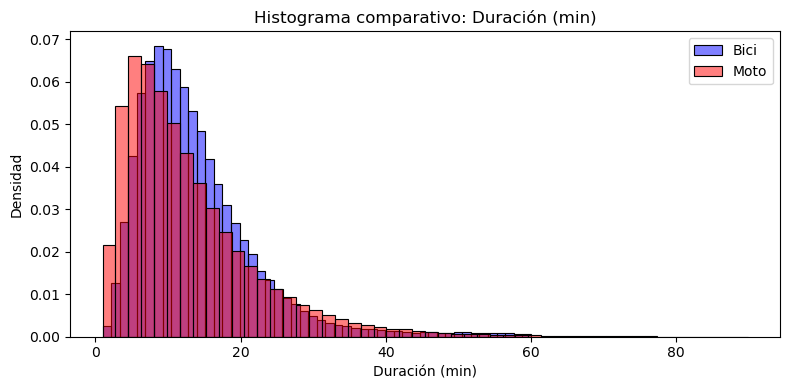

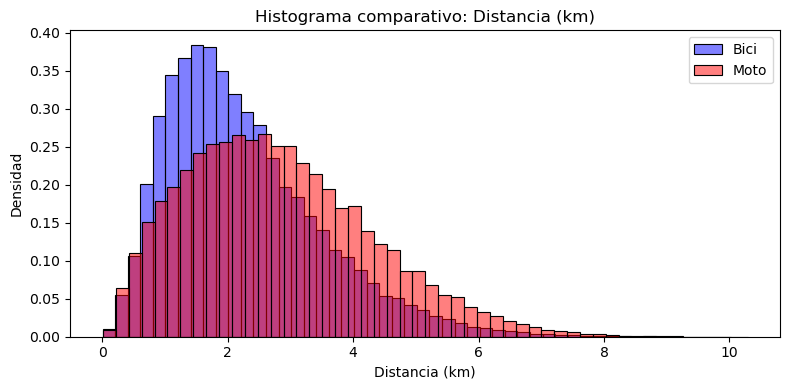

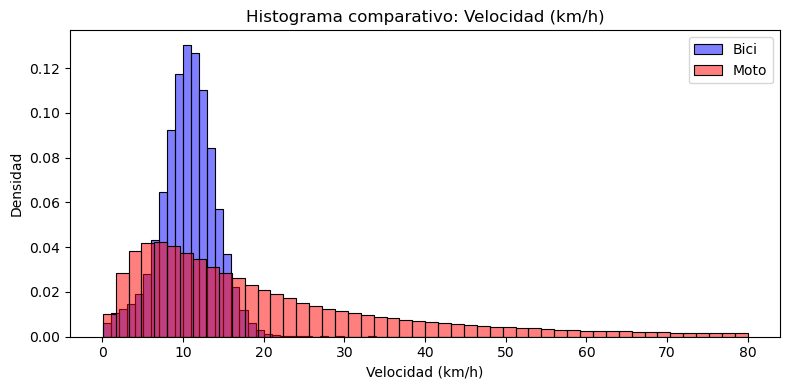

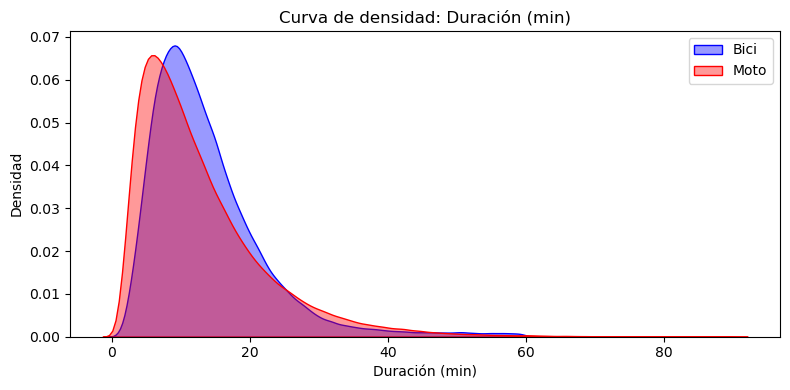

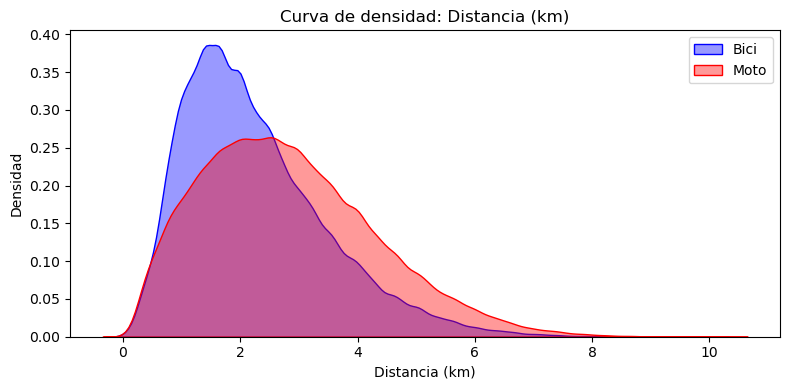

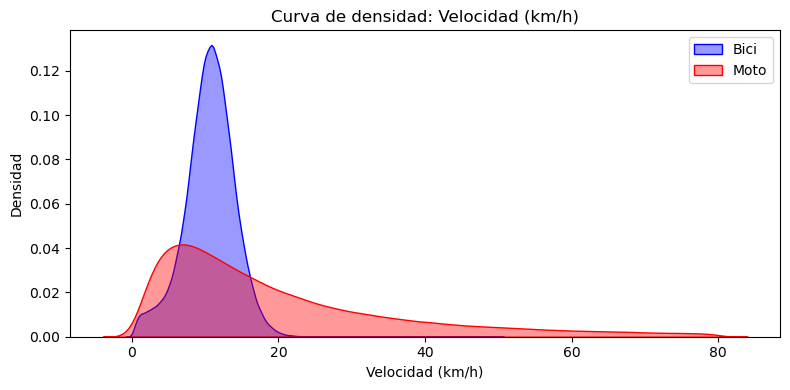

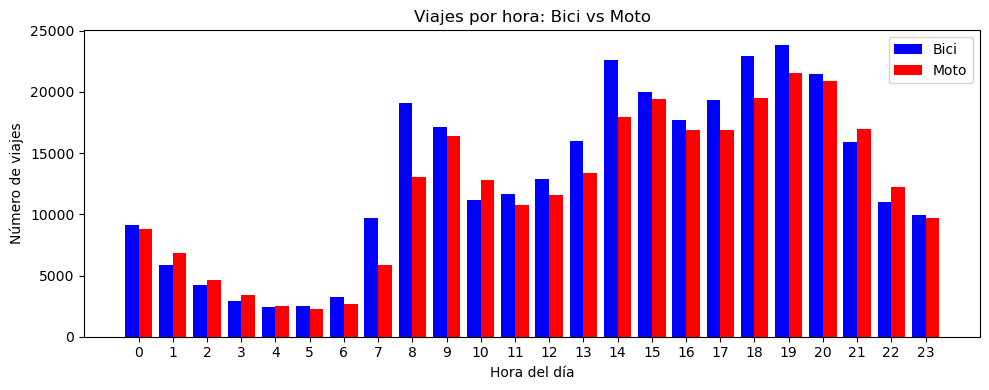

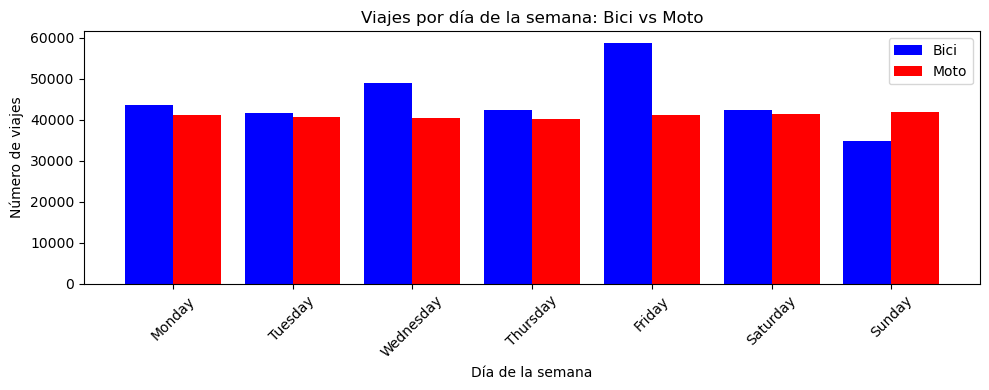

In [117]:
vars_to_plot = ["trip_minutes", "distance_km", "speed_kmh"]
labels = {"trip_minutes": "Duración (min)", "distance_km": "Distancia (km)", "speed_kmh": "Velocidad (km/h)"}

for var in vars_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_bici[var], bins=50, stat="density", alpha=0.5, label="Bici", color="blue")
    sns.histplot(df_moto[var], bins=50, stat="density", alpha=0.5, label="Moto", color="red")
    plt.legend()
    plt.title(f"Histograma comparativo: {labels[var]}")
    plt.xlabel(labels[var])
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 4. Curvas de densidad (KDE)
# -------------------------------

for var in vars_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_bici[var], fill=True, alpha=0.4, label="Bici", color="blue")
    sns.kdeplot(df_moto[var], fill=True, alpha=0.4, label="Moto", color="red")
    plt.legend()
    plt.title(f"Curva de densidad: {labels[var]}")
    plt.xlabel(labels[var])
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 5. Picos horarios y semanales
# -------------------------------

# Preparar columnas temporales
df_bici["hour"]    = df_bici["fecha"].dt.hour
df_moto["hour"]    = df_moto["fecha"].dt.hour
df_bici["weekday"] = df_bici["fecha"].dt.day_name()
df_moto["weekday"] = df_moto["fecha"].dt.day_name()

# 5.1 Viajes por hora
bici_hour = df_bici["hour"].value_counts().sort_index()
moto_hour = df_moto["hour"].value_counts().sort_index()
hours = np.arange(24)

plt.figure(figsize=(10, 4))
plt.bar(hours - 0.2, bici_hour.reindex(hours, fill_value=0), width=0.4, label="Bici", color="blue")
plt.bar(hours + 0.2, moto_hour.reindex(hours, fill_value=0), width=0.4, label="Moto", color="red")
plt.xticks(hours)
plt.xlabel("Hora del día")
plt.ylabel("Número de viajes")
plt.title("Viajes por hora: Bici vs Moto")
plt.legend()
plt.tight_layout()
plt.show()

# 5.2 Viajes por día de la semana
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
bici_w = df_bici["weekday"].value_counts().reindex(order, fill_value=0)
moto_w = df_moto["weekday"].value_counts().reindex(order, fill_value=0)
idx = np.arange(len(order))

plt.figure(figsize=(10, 4))
plt.bar(idx - 0.2, bici_w, width=0.4, label="Bici", color="blue")
plt.bar(idx + 0.2, moto_w, width=0.4, label="Moto", color="red")
plt.xticks(idx, order, rotation=45)
plt.xlabel("Día de la semana")
plt.ylabel("Número de viajes")
plt.title("Viajes por día de la semana: Bici vs Moto")
plt.legend()
plt.tight_layout()
plt.show()